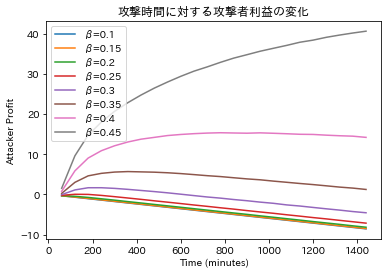

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib

# 日本語フォントの設定
matplotlib.rcParams['font.family'] = 'IPAexGothic'

# bの値のリスト
b_values = ['b01', 'b015', 'b02', 'b025', 'b03', 'b035', 'b04', 'b045']
# 1ブロックあたりの報酬(BTC)
b_reward: float = 6.25
# 1秒あたりのコスト(BTC) 1/21 17:28 51%攻撃に必要な計算コスト$1,550,860/1hours→1%を占めるノードの計算コスト $1,550,860*49/(51*100) / 60 /60 = $4.13900544662/seconds
# 1/21 17:28 1ドル 0.000024BTC
cost_per_sec: float = 4.13900544662 * 0.000024

def b_to_beta(b):
    return float(b[1]+"." +b[2:])


for b in b_values:
    times = []
    attacker_profit_list = []
    
    # ファイル名を生成してデータを読み込む
    for i in range(1, 25):  # 60から1440まで60刻み
        filename = f"../1m/{b}_at{i*60}.csv"
        if os.path.exists(filename):
            data = pd.read_csv(filename,header=None)
            #Attackerの利益を計算 攻撃者の割合がb，攻撃時間がi*60の時の利益を計算．csvファイル中の行分のループを回す．
            attacker_profit = 0
            for j in range(len(data)):
                if data.iloc[j, 1] == 1:
                    attacker_profit += data.iloc[j,3] * b_reward - data.iloc[j, 2] * cost_per_sec
                else:
                    attacker_profit -= data.iloc[j, 2] * cost_per_sec
            #1回あたりの利益をリストに追加
            attacker_profit = attacker_profit / len(data)
            attacker_profit_list.append(attacker_profit)
            times.append(i * 60)
        else:
            print(f"File not found: {filename}")
    
    # bの値をβの値に変換して凡例を設定
    beta_value = b_to_beta(b)  # 例：b01を0.1に変換
    legend_label = f"β={beta_value}"

    # それぞれのbの値についてグラフを描画
    plt.plot(times, attacker_profit_list, label=legend_label)
    
# # 攻撃しなかった場合の利益を計算
# for b in b_values:
#     beta_value = b_to_beta(b)  # 例：b01を0.1に変換
#     times = []
#     attacker_profit_list = []
#     for i in range(1, 25):
#         times.append(i * 60)
#         expeceted_num_of_blocks = i*60/10
#         attacker_profit = expeceted_num_of_blocks * beta_value * b_reward - i*60*60*cost_per_sec
#         attacker_profit_list.append(attacker_profit)
        
#     # 凡例を設定
#     legend_label = f"β={beta_value}, no attack"

#     # それぞれのbの値についてグラフを描画
#     plt.plot(times, attacker_profit_list, label=legend_label)

plt.xlabel('Time (minutes)')
plt.ylabel('Attacker Profit')
plt.title('攻撃時間に対する攻撃者利益の変化')
plt.legend()
plt.show()

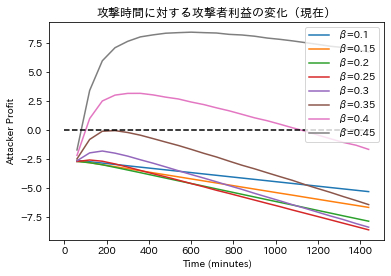

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib

# 日本語フォントの設定
matplotlib.rcParams['font.family'] = 'IPAexGothic'

# bの値のリスト
b_values = ['b01', 'b015', 'b02', 'b025', 'b03', 'b035', 'b04', 'b045']
# 1ブロックあたりの報酬(BTC)
b_reward: float = 6.25 / (2**5)
# DSA報酬
dsa_reward: float = 25
# resell rate
resell_rate: float = 0.9

# Ver① 1秒あたりのコスト(BTC) 1/21 17:28 51%攻撃に必要な計算コスト$1,550,860/1hours→1%を占めるノードの計算コスト $1,550,860*49/(51*100) / 60 /60 = $4.13900544662/seconds
# 1/21 17:28 1ドル 0.000024BTC
# だいたい1.0*10^(-4)ぐらいになる
# cost_per_sec: float = 4.13900544662 * 0.000024

# Ver② 1ビットコインの採掘コスト(ドル）/1BTCが何ドルか = 1ビットコインの採掘コストは1.00 BTC，1ブロックの採掘時間は平均600秒
# これはシステム全体がマイニングしたときの話である．そのため1%あたりに直す
# https://en.macromicro.me/charts/29435/bitcoin-production-total-cost
mining_cost_per_btc: float = 1.00
cost_per_sec: float = b_reward * mining_cost_per_btc / 600 / 100

def b_to_beta(b):
    return float(b[1]+"." +b[2:])


for b in b_values:
    times = []
    attacker_profit_list = []
    beta_value = b_to_beta(b)
    
    # ファイル名を生成してデータを読み込む
    for i in range(1, 25):  # 60から1440まで60刻み
        filename = f"../1m_simple/{b}_at{i*60}.csv"
        if os.path.exists(filename):
            #Attackerの利益を計算 攻撃者の割合がb，攻撃時間がi*60の時の利益を計算．csvファイル中の行分のループを回す．
            # ベクトル化された操作でAttackerの利益を計算
            data = pd.read_csv(filename, header=None, names=['c0', 'c1', 'c2', 'c3'])
            data['profit_plus'] = 0.0 #全行を0.0で初期化
            # 攻撃者の利益を計算（攻撃成功後は普通に残りの時間でマイニング）
            data.loc[data['c1'] == 1, 'profit_plus'] = dsa_reward + data['c3'] * b_reward + (i*60*60 - data['c2'])/600 * beta_value * b_reward
            data['profit_minus'] = i*60*60 * cost_per_sec * beta_value * 100  + (1 - resell_rate) * dsa_reward
            #攻撃者の利益を計算（攻撃成功後は普通に残りの時間でマイニングし「ない」）
            # data.loc[data['c1'] == 1, 'profit_plus'] = dsa_reward + data['c3'] * b_reward
            # data['profit_minus'] = data['c2'] * cost_per_sec * beta_value * 100 + (1 - resell_rate) * dsa_reward
            data['profit'] = data['profit_plus'] - data['profit_minus']
            
            attacker_profit = data['profit'].sum() / len(data)
            attacker_profit_list.append(attacker_profit)
            times.append(i * 60)
        else:
            print(f"File not found: {filename}")
    
    # bの値をβの値に変換して凡例を設定
    beta_value = b_to_beta(b)  # 例：b01を0.1に変換
    legend_label = f"β={beta_value}"

    # それぞれのbの値についてグラフを描画
    plt.plot(times, attacker_profit_list, label=legend_label)
    
# 攻撃しなかった場合の利益を計算
# for b in b_values:
#     beta_value = b_to_beta(b)  # 例：b01を0.1に変換
#     times = []
#     attacker_profit_list = []
#     for i in range(1, 25):
#         times.append(i * 60)
#         expeceted_num_of_blocks = i*60/10
#         attacker_profit = expeceted_num_of_blocks * beta_value * b_reward - i*60*60*cost_per_sec*beta_value*100
#         attacker_profit_list.append(attacker_profit)
        
#     # 凡例を設定
#     legend_label = f"β={beta_value}, no attack"

#     # それぞれのbの値についてグラフを描画
#     plt.plot(times, attacker_profit_list, label=legend_label)
    
# y = 0の直線をグラフに描画（わかりやすい色で）
plt.plot([0, 1440], [0, 0], color='black', linestyle='dashed')

plt.xlabel('Time (minutes)')
plt.ylabel('Attacker Profit')
plt.title('攻撃時間に対する攻撃者利益の変化（現在）')
plt.legend()
plt.show()

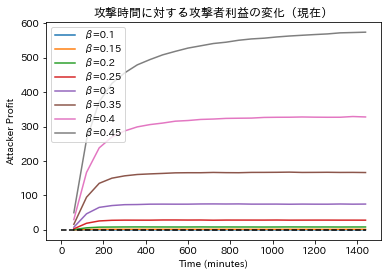

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib

# 日本語フォントの設定
matplotlib.rcParams['font.family'] = 'IPAexGothic'

# bの値のリスト
b_values = ['b01', 'b015', 'b02', 'b025', 'b03', 'b035', 'b04', 'b045']
# 1ブロックあたりの報酬(BTC)
b_reward: float = 6.25 / (2**10)
# DSA報酬
dsa_reward: float = 10
# resell rate
resell_rate: float = 1

# Ver① 1秒あたりのコスト(BTC) 1/21 17:28 51%攻撃に必要な計算コスト$1,550,860/1hours→1%を占めるノードの計算コスト $1,550,860*49/(51*100) / 60 /60 = $4.13900544662/seconds
# 1/21 17:28 1ドル 0.000024BTC
# だいたい1.0*10^(-4)ぐらいになる
# cost_per_sec: float = 4.13900544662 * 0.000024

# Ver② 1ビットコインの採掘コスト(ドル）/1BTCが何ドルか = 1ビットコインの採掘コストは1.00 BTC，1ブロックの採掘時間は平均600秒
# これはシステム全体がマイニングしたときの話である．そのため1%あたりに直す
# https://en.macromicro.me/charts/29435/bitcoin-production-total-cost
mining_cost_per_btc: float = 1.00
cost_per_sec: float = b_reward * mining_cost_per_btc / 600 / 100

def b_to_beta(b):
    return float(b[1]+"." +b[2:])


for b in b_values:
    times = []
    attacker_profit_list = []
    beta_value = b_to_beta(b)
    
    # ファイル名を生成してデータを読み込む
    for i in range(1, 25):  # 60から1440まで60刻み
        filename = f"../1m_simple/{b}_at{i*60}.csv"
        if os.path.exists(filename):
            #Attackerの利益を計算 攻撃者の割合がb，攻撃時間がi*60の時の利益を計算．csvファイル中の行分のループを回す．
            # ベクトル化された操作でAttackerの利益を計算
            data = pd.read_csv(filename, header=None, names=['c0', 'c1', 'c2', 'c3'])
            data['profit_plus'] = 0.0 #全行を0.0で初期化
            # 攻撃者の利益を計算 勝ったらすぐに計算をやめる
            data.loc[data['c1'] == 1, 'profit_plus'] = dsa_reward + data['c3'] * b_reward
            # 計算してた時間のコスト計算
            data['profit_minus'] = data['c2'] * cost_per_sec * beta_value * 100  + (1 - resell_rate) * dsa_reward
            
            data['profit'] = data['profit_plus'] - data['profit_minus']
            
            attacker_profit = data['profit'].sum() / len(data)
            attacker_profit_list.append(attacker_profit)
            times.append(i * 60)
        else:
            print(f"File not found: {filename}")
    
    # bの値をβの値に変換して凡例を設定
    beta_value = b_to_beta(b)  # 例：b01を0.1に変換
    legend_label = f"β={beta_value}"

    # それぞれのbの値についてグラフを描画
    plt.plot(times, attacker_profit_list, label=legend_label)
    
# 攻撃しなかった場合の利益を計算
# for b in b_values:
#     beta_value = b_to_beta(b)  # 例：b01を0.1に変換
#     times = []
#     attacker_profit_list = []
#     for i in range(1, 25):
#         times.append(i * 60)
#         expeceted_num_of_blocks = i*60/10
#         attacker_profit = expeceted_num_of_blocks * beta_value * b_reward - i*60*60*cost_per_sec*beta_value*100
#         attacker_profit_list.append(attacker_profit)
        
#     # 凡例を設定
#     legend_label = f"β={beta_value}, no attack"

#     # それぞれのbの値についてグラフを描画
#     plt.plot(times, attacker_profit_list, label=legend_label)
    
# y = 0の直線をグラフに描画（わかりやすい色で）
plt.plot([0, 1440], [0, 0], color='black', linestyle='dashed')

plt.xlabel('Time (minutes)')
plt.ylabel('Attacker Profit')
plt.title('攻撃時間に対する攻撃者利益の変化（現在）')
plt.legend()
plt.show()